# MNIST

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
torch.manual_seed(1)

## Choose Device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    kwargs = {'num_workers': 1, 'pin_memory': True}
else:
    device = torch.device("cpu")
    kwargs = {}

## Load and visualize data set

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
testset = datasets.MNIST('./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True, **kwargs)

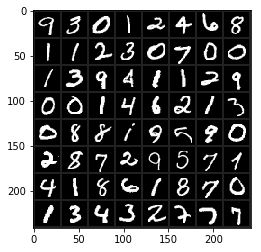

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img * 0.3081 + 0.1307 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show image
imshow(torchvision.utils.make_grid(images))

In [6]:
torchvision.utils.make_grid(images).shape

torch.Size([3, 242, 242])

## define network

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 30, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(30*4*4, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 30*4*4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
net = Net().to(device)

## Train

In [9]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_loss = []
for epoch in range(20):
    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        output = net(x)
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        
    print('Train Epoch: {:>2} \tLoss: {:.6f}'.format(epoch, loss.item()))

Train Epoch:  0 	Loss: 0.060963
Train Epoch:  1 	Loss: 0.130430
Train Epoch:  2 	Loss: 0.064768
Train Epoch:  3 	Loss: 0.044731
Train Epoch:  4 	Loss: 0.044445
Train Epoch:  5 	Loss: 0.027767
Train Epoch:  6 	Loss: 0.003582
Train Epoch:  7 	Loss: 0.021736
Train Epoch:  8 	Loss: 0.162622
Train Epoch:  9 	Loss: 0.107828
Train Epoch: 10 	Loss: 0.105701
Train Epoch: 11 	Loss: 0.162714
Train Epoch: 12 	Loss: 0.044509
Train Epoch: 13 	Loss: 0.006101
Train Epoch: 14 	Loss: 0.019899
Train Epoch: 15 	Loss: 0.193086
Train Epoch: 16 	Loss: 0.002142
Train Epoch: 17 	Loss: 0.000378
Train Epoch: 18 	Loss: 0.000164
Train Epoch: 19 	Loss: 0.013076


## plot loss

Text(0, 0.5, 'loss')

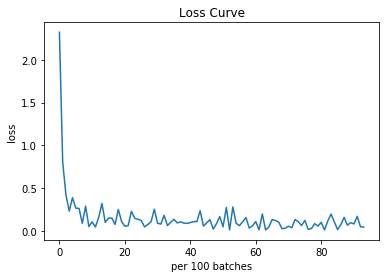

In [41]:
plt.plot(train_loss[1::100])
plt.title("Loss Curve")
plt.xlabel("per 100 batches")
plt.ylabel("loss")

## Test

In [40]:
test_loss = 0
correct = 0
with torch.no_grad():
    for (x, y) in test_loader:
        x, y = x.to(device), y.to(device)
        output = net(x)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()
        test_loss += F.nll_loss(output, y, reduction='sum').item()
    
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0853, Accuracy: 9736/10000 (97%)

